<a href="https://colab.research.google.com/github/gabrielfea/CMAPSSData/blob/main/Estudo_base_CMAPSS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
!pip install tensorflow -q
!pip install tabulate -q

In [26]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Layer, MultiHeadAttention, Dropout, LayerNormalization, Flatten, Reshape
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from tabulate import tabulate

In [27]:
# Função para carregar os dados
def load_data(file_path):
    data = pd.read_csv(file_path, sep=' ', header=None)
    data.dropna(axis=1, how='all', inplace=True)
    return data.values

In [28]:
# Função para preparar os dados de treinamento
def prepare_train_data(data, sequence_length):
    X, y = [], []
    for unit in np.unique(data[:, 0]):
        unit_data = data[data[:, 0] == unit]
        for i in range(len(unit_data) - sequence_length + 1):
            X.append(unit_data[i:i+sequence_length, 2:])
            y.append(len(unit_data) - i - sequence_length)
    return np.array(X), np.array(y)

In [29]:

# Função para preparar os dados de teste
def prepare_test_data(data, sequence_length):
    X = []
    for unit in np.unique(data[:, 0]):
        unit_data = data[data[:, 0] == unit]
        if len(unit_data) >= sequence_length:
            X.append(unit_data[-sequence_length:, 2:])
        else:
            pad_size = sequence_length - len(unit_data)
            padded_data = np.pad(unit_data[:, 2:], ((pad_size, 0), (0, 0)), 'constant')
            X.append(padded_data)
    return np.array(X)

In [30]:
# Transformer Encoder Layer
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim)]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [31]:

# Função para construir o modelo
def build_model(input_shape):
    inputs = Input(shape=input_shape)

    # CNN
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2)(x)

    # LSTM
    x = LSTM(100, return_sequences=True)(x)
    x = LSTM(100, return_sequences=False)(x)

    # Transformer
    transformer_block = TransformerBlock(embed_dim=100, num_heads=2, ff_dim=64)
    x = transformer_block(tf.expand_dims(x, axis=1))

    # Flatten and Dense
    x = Flatten()(x)
    outputs = Dense(1)(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [32]:

# Função para calcular as métricas
def evaluate_model(y_true, y_pred):
    metrics = {
        'Metric': ['R²', 'MAPE', 'MAE', 'MSE', 'RMSE'],
        'Value': [
            r2_score(y_true, y_pred),
            mean_absolute_percentage_error(y_true, y_pred),
            mean_absolute_error(y_true, y_pred),
            mean_squared_error(y_true, y_pred),
            np.sqrt(mean_squared_error(y_true, y_pred))
        ]
    }

    df_metrics = pd.DataFrame(metrics)
    print(tabulate(df_metrics, headers='keys', tablefmt='pretty'))

In [33]:

# Função para plotar o histórico de treinamento
def plot_training_history(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss During Training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [34]:
# Função para plotar as previsões de RUL como scatter plot com linhas ajustadas
def plot_rul_predictions(y_true, y_pred):
    plt.figure(figsize=(14, 8))  # Aumentar a largura do gráfico
    indices = np.arange(len(y_true))

    plt.scatter(indices, y_true, label='True RUL', color='blue', marker='o', facecolors='none')
    plt.scatter(indices, y_pred, label='Predicted RUL', color='red', marker='x')

    # Adicionar linhas finas pretas entre previsões e valores reais
    for i in range(len(y_true)):
        if y_pred[i] < y_true[i]:
            plt.plot([i, i], [y_true[i], y_pred[i]], color='green', linewidth=2)
        else:
            plt.plot([i, i], [y_true[i], y_pred[i]], color='red', linewidth=2)

    plt.title('RUL Predictions vs True RUL')
    plt.xlabel('Sample Index')
    plt.ylabel('RUL Cycles')
    plt.legend()
    plt.show()

In [36]:
#Função para executar o processo para um determinado conjunto de dados
def process_data(set_num):
    # Carregar dados
    data_train = load_data(f'{data_path}train_FD00{set_num}.txt')
    data_test = load_data(f'{data_path}test_FD00{set_num}.txt')
    data_rul = load_data(f'{data_path}RUL_FD00{set_num}.txt').flatten()

    # Escalar dados
    scaler = MinMaxScaler()
    data_train[:, 2:] = scaler.fit_transform(data_train[:, 2:])
    data_test[:, 2:] = scaler.transform(data_test[:, 2:])

    # Preparar dados
    sequence_length = 200
    X_train, y_train = prepare_train_data(data_train, sequence_length)
    X_test = prepare_test_data(data_test, sequence_length)

    # Construir modelo
    input_shape = (X_train.shape[1], X_train.shape[2])
    model = build_model(input_shape)

    # Early Stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Treinar modelo
    history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

    # Fazer previsões
    y_pred = model.predict(X_test).flatten()

    # Avaliar modelo
    evaluate_model(data_rul, y_pred)

    # Plotar histórico de treinamento
    plot_training_history(history)

    # Plotar previsões de RUL
    plot_rul_predictions(data_rul, y_pred)

Processando conjunto de dados FD001...
Epoch 1/100
26/26 [==============================] - 15s 362ms/step - loss: 1581.0956 - val_loss: 2760.2637
Epoch 2/100
26/26 [==============================] - 6s 216ms/step - loss: 1389.7567 - val_loss: 2542.8291
Epoch 3/100
26/26 [==============================] - 8s 311ms/step - loss: 1289.4117 - val_loss: 2333.4287
Epoch 4/100
26/26 [==============================] - 6s 215ms/step - loss: 1200.5177 - val_loss: 2135.5076
Epoch 5/100
26/26 [==============================] - 8s 318ms/step - loss: 1026.4336 - val_loss: 1849.8094
Epoch 6/100
26/26 [==============================] - 6s 216ms/step - loss: 863.5970 - val_loss: 1592.8898
Epoch 7/100
26/26 [==============================] - 7s 253ms/step - loss: 729.5835 - val_loss: 1363.1393
Epoch 8/100
26/26 [==============================] - 7s 270ms/step - loss: 624.7575 - val_loss: 1151.3798
Epoch 9/100
26/26 [==============================] - 6s 215ms/step - loss: 528.9894 - val_loss: 970.1172
Ep

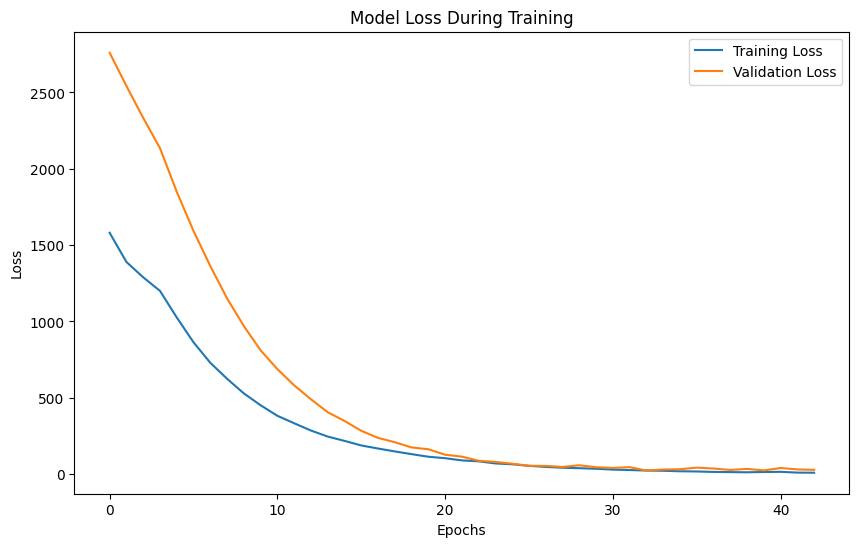

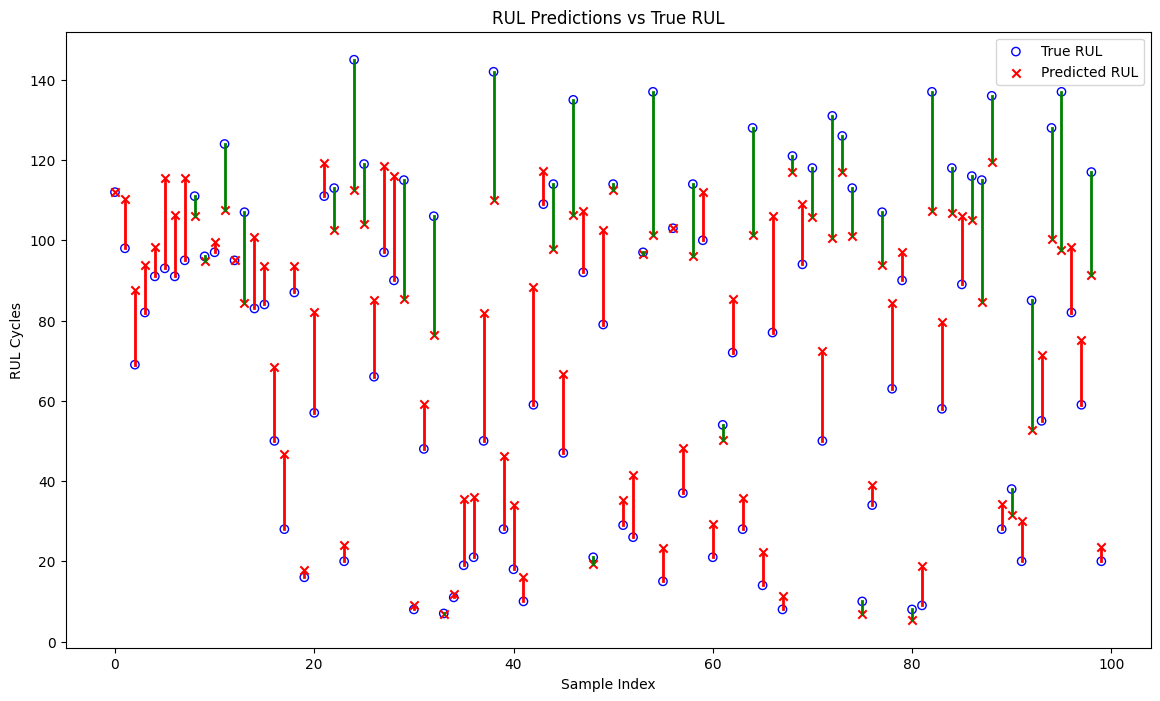

Conjunto de dados FD001 processado.

Processando conjunto de dados FD002...
Epoch 1/100
70/70 [==============================] - 29s 283ms/step - loss: 1746.8073 - val_loss: 1189.2094
Epoch 2/100
70/70 [==============================] - 19s 267ms/step - loss: 1407.2484 - val_loss: 996.8220
Epoch 3/100
70/70 [==============================] - 18s 263ms/step - loss: 1260.6375 - val_loss: 950.4598
Epoch 4/100
70/70 [==============================] - 20s 290ms/step - loss: 1226.4656 - val_loss: 950.4069
Epoch 5/100
70/70 [==============================] - 18s 262ms/step - loss: 1223.2694 - val_loss: 954.2941
Epoch 6/100
70/70 [==============================] - 18s 260ms/step - loss: 1226.0852 - val_loss: 956.4124
Epoch 7/100
70/70 [==============================] - 18s 260ms/step - loss: 1223.6676 - val_loss: 958.0274
Epoch 8/100
70/70 [==============================] - 18s 262ms/step - loss: 1224.3915 - val_loss: 954.4676
Epoch 9/100
70/70 [==============================] - 20s 286ms/step

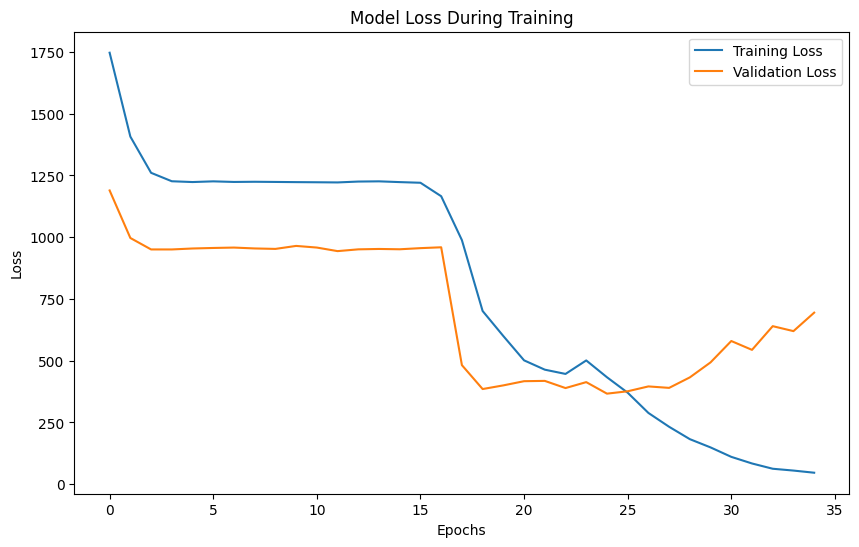

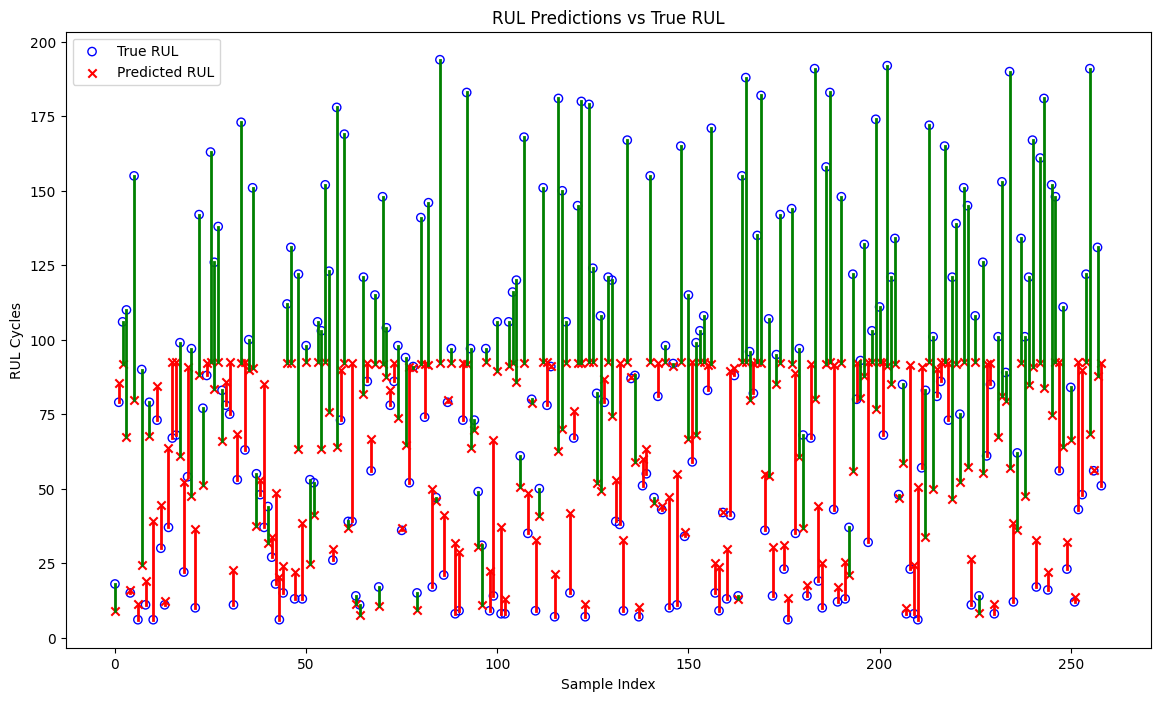

Conjunto de dados FD002 processado.

Processando conjunto de dados FD003...
Epoch 1/100
71/71 [==============================] - 27s 287ms/step - loss: 9816.8252 - val_loss: 8327.3496
Epoch 2/100
71/71 [==============================] - 18s 254ms/step - loss: 8463.9473 - val_loss: 7039.2720
Epoch 3/100
71/71 [==============================] - 18s 253ms/step - loss: 7127.6973 - val_loss: 5676.3096
Epoch 4/100
71/71 [==============================] - 18s 249ms/step - loss: 5528.4907 - val_loss: 4252.2266
Epoch 5/100
71/71 [==============================] - 19s 265ms/step - loss: 4173.8975 - val_loss: 3105.9595
Epoch 6/100
71/71 [==============================] - 20s 279ms/step - loss: 3083.2078 - val_loss: 2314.5232
Epoch 7/100
71/71 [==============================] - 18s 256ms/step - loss: 2295.8977 - val_loss: 1716.9926
Epoch 8/100
71/71 [==============================] - 18s 253ms/step - loss: 1683.3956 - val_loss: 1347.4945
Epoch 9/100
71/71 [==============================] - 18s 254

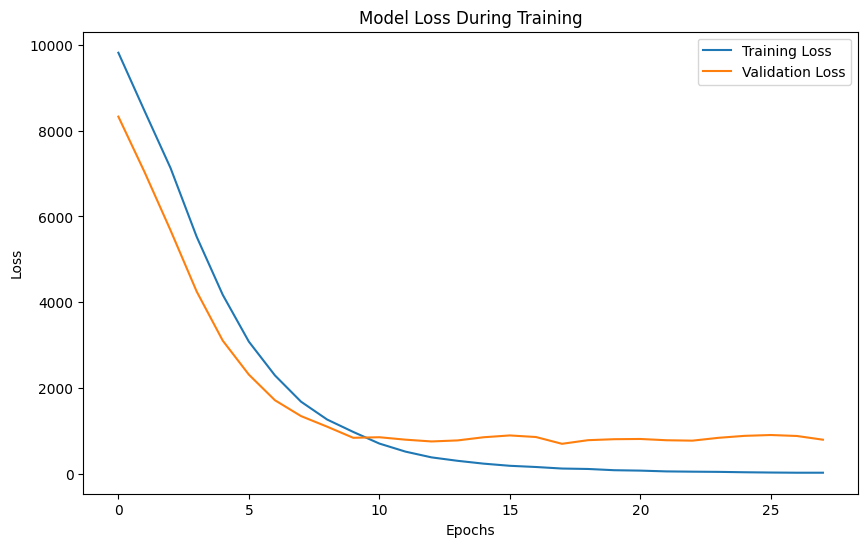

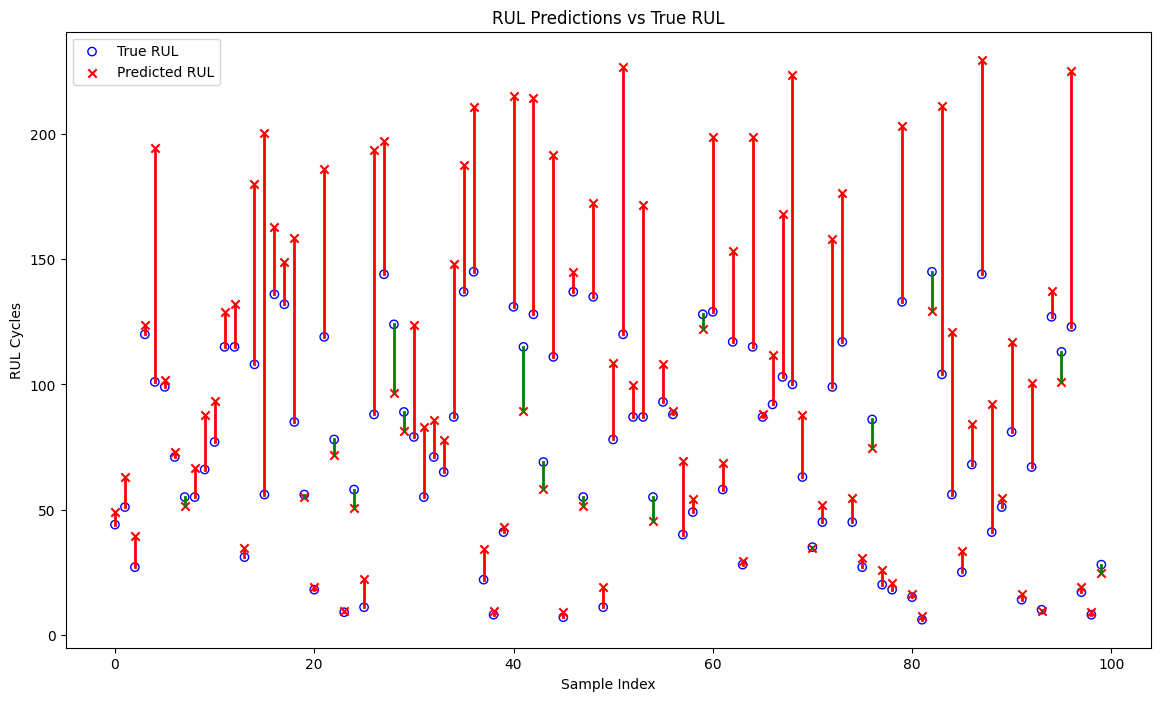

Conjunto de dados FD003 processado.

Processando conjunto de dados FD004...
Epoch 1/100
173/173 [==============================] - 52s 266ms/step - loss: 5157.7622 - val_loss: 2508.5017
Epoch 2/100
173/173 [==============================] - 44s 257ms/step - loss: 3584.1389 - val_loss: 2178.6206
Epoch 3/100
173/173 [==============================] - 43s 250ms/step - loss: 3312.1880 - val_loss: 2273.9939
Epoch 4/100
173/173 [==============================] - 44s 253ms/step - loss: 3307.7827 - val_loss: 2261.9585
Epoch 5/100
173/173 [==============================] - 57s 329ms/step - loss: 3306.4297 - val_loss: 2273.8301
Epoch 6/100
173/173 [==============================] - 45s 259ms/step - loss: 3299.8789 - val_loss: 2308.4863
Epoch 7/100
173/173 [==============================] - 46s 264ms/step - loss: 3309.2849 - val_loss: 2331.0862
Epoch 8/100
173/173 [==============================] - 47s 269ms/step - loss: 3297.9146 - val_loss: 1933.5765
Epoch 9/100
173/173 [=======================

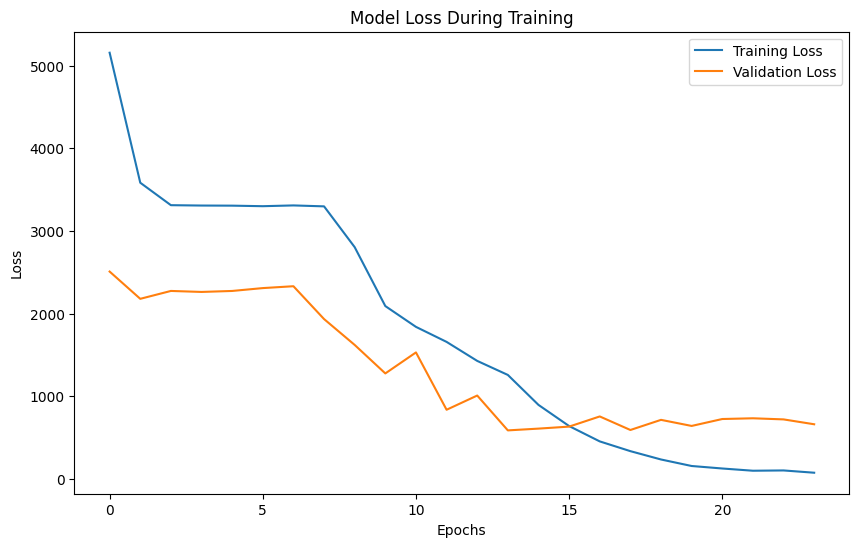

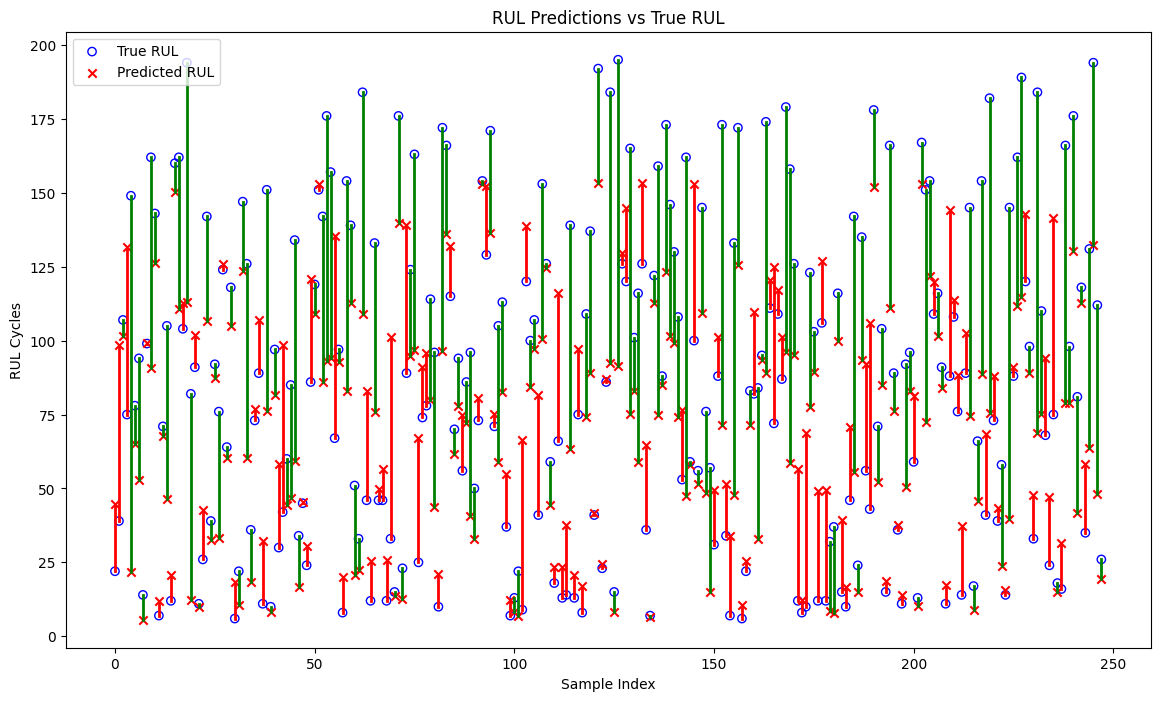

Conjunto de dados FD004 processado.



In [37]:
# Loop para processar os conjuntos de dados do 1 ao 4
for i in range(1, 5):
    print(f'Processando conjunto de dados FD00{i}...')
    process_data(i)
    print(f'Conjunto de dados FD00{i} processado.\n')